In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mbornoe/lisa-traffic-light-dataset")

# print("Path to dataset files:", path)

100%|████████████████████████████████████████████████████████████| 4.21G/4.21G [01:14<00:00, 60.8MB/s]

Extracting files...


Path to dataset files: /home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2


In [115]:
import os
import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
from pathlib import Path
import matplotlib.pyplot as plt

database_path = '/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/'
target_classes = ['go', 'stop', 'warning','background']
color_map = {'go':'green', 'stop':'red', 'warning':'yellow','background':'gray'}
# rgb_color_map = {'go': (0, 255, 0), 'stop': (255, 0, 0), 'warning': (255, 255, 0)}

train_folder_list = [
    'dayTrain',
#     'daySequence1',
#     'daySequence2',
#     'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 5000

def get_annotarion_dataframe(train_data_folders):
    data_base_path = '/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/'
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    return df

In [116]:
train_annotation_df = get_annotarion_dataframe(train_folder_list)
    
clips = {}
img_dir = Path(os.path.join(database_path, 'dayTrain/dayTrain'))
print(img_dir)
    
# Walk through all clip directories
for clip_dir in img_dir.glob('dayClip*/frames'):
    # Extract clip name from path
    clip_name = clip_dir.parents[0].name + '--'  # e.g., 'dayClip13--'

    # Get all image files in frames directory
    frame_files = [f for f in clip_dir.glob('*.jpg')]

    # Extract frame numbers
    for frame_path in frame_files:
        # Extract frame number from filename (e.g., '00000' from 'dayClip13--00000.jpg')
        frame_num = int(frame_path.stem.split('--')[-1])

        if clip_name.strip('-') not in clips:
            clips[clip_name.strip('-')] = set()
        clips[clip_name.strip('-')].add(frame_num)

positive_frames = set(train_annotation_df['filename'].unique())
for clip_name, frame_nums in clips.items():
    for frame_num in frame_nums:
        filename = f"{clip_name}--{frame_num:05d}.jpg"
        if filename not in positive_frames:
            train_annotation_df = pd.concat([pd.DataFrame([[filename,'background', 0,0,0,0,f"{img_dir}/{clip_name}/frames/{filename}"]], 
                                                          columns=train_annotation_df.columns), 
                                             train_annotation_df], 
                                            ignore_index=True)

target_classes = train_annotation_df['target'].unique()
target_classes.sort()

train_annotation_df

/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/dayTrain/dayTrain


,filename,target,x1,y1,x2,y2,image_path
0,dayClip7--02718.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
1,dayClip7--02717.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
2,dayClip7--02716.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
3,dayClip7--02715.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
4,dayClip7--02714.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
...,...,...,...,...,...,...,...
31058,dayClip1--02160.jpg,go,660,322,672,342,/home/ttran02/.cache/kagglehub/datasets/mborno...
31059,dayClip1--02160.jpg,go,777,351,792,376,/home/ttran02/.cache/kagglehub/datasets/mborno...
31060,dayClip1--02160.jpg,go,838,174,868,234,/home/ttran02/.cache/kagglehub/datasets/mborno...
31061,dayClip1--02160.jpg,go,987,213,1014,263,/home/ttran02/.cache/kagglehub/datasets/mborno...


In [107]:
train_annotation_df.image_path.iloc[12]

'/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/dayTrain/dayTrain/dayClip7/frames/dayClip7--02706.jpg'

In [118]:
def resample_dataset(annotation_df, n_samples):
    df_resample_list = list()
    for target in target_classes:
        df = annotation_df[annotation_df['target'] == target].copy()
        df_r = resample(df, n_samples=n_samples, random_state=42)
        df_resample_list.append(df_r)
    return pd.concat(df_resample_list).reset_index(drop=True)

train_annotation_df = resample_dataset(train_annotation_df, n_samples_per_class)

target
background    5000
go            5000
stop          5000
warning       5000
Name: count, dtype: int64

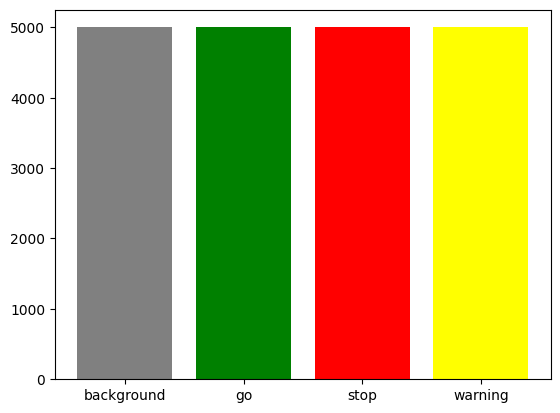

In [119]:
index, counts = np.unique(train_annotation_df['target'], return_counts=True)
colors = [color_map[target] for target in index]
plt.bar(index, counts, color=colors);
train_annotation_df['target'].value_counts()

In [120]:
train_annotation_df['target'].value_counts()

target
background    5000
go            5000
stop          5000
warning       5000
Name: count, dtype: int64

In [147]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import re
from pathlib import Path
import numpy as np

import torchvision.transforms as T
import torchvision.transforms.functional as F

class TrafficLightDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        Args:
            df: DataFrame with traffic light annotations
            img_dir: Directory containing all images
            transform: Optional transforms to be applied on images
            include_negatives: Whether to include frames without traffic lights
        """
        self.df = df
        self.img_dir = Path(img_dir)
        self.transform = transform
        
        # Group annotations by filename
        self.grouped_annotations = df.groupby('filename')
        
        # Get all unique filenames with annotations
        self.frames = list(set(df['filename'].unique()))
        
        # Extract all potential frame numbers and organize by clip
#         self.clips = self._organize_clips()
        
        # Create final list of all samples (positive and negative)
#         self.all_samples = self._create_sample_list()
        
#     def _organize_clips(self):
#         """Organize frames into clips and identify missing frame numbers"""
#         clips = {}
# #         img_dir = Path(os.path.join(database_path, 'dayTrain/dayTrain'))
# #         print(img_dir)

#         # Walk through all clip directories
#         for clip_dir in self.img_dir.glob('dayClip*/frames'):
#             # Extract clip name from path
#             clip_name = clip_dir.parents[0].name + '--'  # e.g., 'dayClip13--'

#             # Get all image files in frames directory
#             frame_files = [f for f in clip_dir.glob('*.jpg')]

#             # Extract frame numbers
#             for frame_path in frame_files:
#                 # Extract frame number from filename (e.g., '00000' from 'dayClip13--00000.jpg')
#                 frame_num = int(frame_path.stem.split('--')[-1])

#                 if clip_name.strip('-') not in clips:
#                     clips[clip_name.strip('-')] = set()
#                 clips[clip_name.strip('-')].add(frame_num)

#         return clips
    
#     def _create_sample_list(self):
#         """Create list of all samples, including both positive and negative frames"""
#         samples = []
        
#         # Add all frames that have traffic lights (positive samples)
#         for filename in self.positive_frames:
#             clip_name, frame_num = filename.split('--')
#             filename = f"{clip_name}/frames/{clip_name}--{frame_num}"
#             samples.append((filename, True))
        
#         if self.include_negatives:
#             # Add frames without traffic lights (negative samples)
#             for clip_name, frame_nums in self.clips.items():
#                 for frame_num in frame_nums:
#                     filename = f"{clip_name}/frames/{clip_name}--{frame_num:05d}.jpg"
#                     if filename not in self.positive_frames:
#                         samples.append((filename, False))
        
#         return samples
    
    def _get_boxes_and_labels(self, filename):
#         filename = filename.split('/')[-1]
        
        """Get all bounding boxes and labels for a given image"""
#         if filename not in self.positive_frames:
#             return torch.zeros((0, 4)), torch.zeros(0, dtype=torch.long)
        
        annotations = self.grouped_annotations.get_group(filename)
        boxes = torch.tensor([[row.x1, row.y1, row.x2, row.y2] 
                            for _, row in annotations.iterrows()], dtype=torch.float32)
        
        # Convert string labels to integers
        label_map = {'background': 0, 'stop': 1, 'go': 2, 'warning': 3}
        labels = torch.tensor([label_map[label] for label in annotations['target']], 
                            dtype=torch.long)
        
        return boxes, labels
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        filename = self.frames[idx]
        
#         print(filename)
#         import pdb;pdb.set_trace()
        
        # Load image
        clip_name = filename.split('--')[0]
        img_path = self.img_dir / clip_name / "frames" / filename
        print(img_path)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Get boxes and labels
        boxes, labels = self._get_boxes_and_labels(filename)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64),
            'filename': filename,
        }
        
        return image, target
    
class TrafficLightDataset(Dataset):
    def __init__(self, df, img_dir, target_size=(64,64), transform=None, 
                 scaling_factor=14):
        """
        Args:
            df: DataFrame with traffic light annotations
            img_dir: Directory containing all images
            target_size: Tuple of (height, width) for resizing
            transform: Optional additional transforms to be applied after resizing
        """
        self.df = df
        self.img_dir = Path(img_dir)
        self.target_size = target_size 
        self.scaling_factor = scaling_factor
        self.additional_transform = transform
        
        # Group annotations by filename
        self.grouped_annotations = df.groupby('filename')
        
        # Get all unique filenames with annotations
        self.frames = list(set(df['filename'].unique()))
        
        # Label mapping
        self.label_map = {'background': 0, 'stop': 1, 'go': 2, 'warning': 3}
        
    def _resize_image_and_boxes(self, image, boxes):
        """
        Resize image and adjust bounding boxes accordingly
        """
        # Get original size
        orig_w, orig_h = image.size
#         print("sf, w, h", self.scaling_factor, orig_w, orig_h)
        target_h, target_w = (orig_w // self.scaling_factor, orig_h // self.scaling_factor) \
                                    if self.scaling_factor else self.target_size
        self.target_size = target_h, target_w
#         print("w, h", target_h, target_w)
        
        # Compute scaling factors
        w_scale = target_w / orig_w
        h_scale = target_h / orig_h
        
        # Resize image
        image = F.resize(image, self.target_size)
        
        if len(boxes):
            # Scale bounding boxes
            scaled_boxes = boxes.clone()
            scaled_boxes[:, [0, 2]] *= w_scale  # scale x coordinates
            scaled_boxes[:, [1, 3]] *= h_scale  # scale y coordinates
            
            # Clamp boxes to image boundaries
            scaled_boxes[:, [0, 2]] = torch.clamp(scaled_boxes[:, [0, 2]], 0, target_w)
            scaled_boxes[:, [1, 3]] = torch.clamp(scaled_boxes[:, [1, 3]], 0, target_h)
            
            return image, scaled_boxes
        
        return image, boxes
    
    def _get_boxes_and_labels(self, filename):
        """Get all bounding boxes and labels for a given image"""
        annotations = self.grouped_annotations.get_group(filename)
        boxes = torch.tensor([[row.x1, row.y1, row.x2, row.y2] 
                            for _, row in annotations.iterrows()], dtype=torch.float32)
        
        labels = torch.tensor([self.label_map[label] for label in annotations['target']], 
                            dtype=torch.long)
        
        return boxes, labels
    
    def _validate_boxes(self, boxes):
        """Remove invalid boxes (those with zero width or height after resizing)"""
        if len(boxes) == 0:
            return boxes, torch.zeros(0, dtype=torch.long)
        
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        valid_boxes = (widths > 1) & (heights > 1)
        
        return boxes[valid_boxes], valid_boxes
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        filename = self.frames[idx]
        
        # Load image
        clip_name = filename.split('--')[0]
        img_path = self.img_dir / clip_name / "frames" / filename
        image = Image.open(img_path).convert('RGB')
        
        # Get original boxes and labels
        boxes, labels = self._get_boxes_and_labels(filename)
        
        # Resize image and adjust boxes
        image, boxes = self._resize_image_and_boxes(image, boxes)
        
        # Validate boxes after resizing
        boxes, valid_indices = self._validate_boxes(boxes)
        if len(valid_indices) < len(labels):
            labels = labels[valid_indices]
        
        # Apply any additional transforms
        if self.additional_transform:
            image = self.additional_transform(image)
        
        # Convert PIL to tensor if not done by transforms
        if isinstance(image, Image.Image):
            image = F.to_tensor(image)
        
        # Create target dictionary
        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx]),
            'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
            'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64),
            'filename': filename,
        }
        
        return image, target

# Example usage:
def create_traffic_light_data_loader(
    df, img_dir, batch_size=4, transform=None, include_negatives=True, num_workers=4
):
    """
    Create data loader for traffic light detection
    """
    from torch.utils.data import DataLoader
    
    dataset = TrafficLightDataset(
        df=df,
        img_dir=img_dir,
        transform=transform
    )
    
    # Custom collate function to handle variable number of objects
    def collate_fn(batch):
        return tuple(zip(*batch))
    
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        collate_fn=collate_fn
    )

# Example transforms
def get_transforms(train=True):
    from torchvision import transforms
    
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])

# Usage example:
# """
# Create train loader
train_loader = create_traffic_light_data_loader(
    df=train_annotation_df,
    img_dir='/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/dayTrain/dayTrain',
    batch_size=1,
    transform=get_transforms(train=True),
)

# Iterate through batches
for images, targets in train_loader:
    # images is a list of tensor images
    # targets is a list of dictionaries containing:
    #   - boxes: tensor of shape (num_objects, 4)
    #   - labels: tensor of shape (num_objects,)
    #   - image_id: tensor of shape (1,)
    #   - area: tensor of shape (num_objects,)
    #   - iscrowd: tensor of shape (num_objects,)
    print(images[0].shape)
    break
# """

torch.Size([3, 91, 68])


In [122]:
train_loader.dataset

In [123]:
train_annotation_df.groupby("filename").get_group("dayClip13--00254.jpg")

,filename,target,x1,y1,x2,y2,image_path
1210,dayClip13--00254.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
1559,dayClip13--00254.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
3310,dayClip13--00254.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...
4364,dayClip13--00254.jpg,background,0,0,0,0,/home/ttran02/.cache/kagglehub/datasets/mborno...


In [138]:
images, targets

((tensor([[[-1.5870, -1.5870, -1.5528,  ..., -0.9877, -0.9877, -1.1760],
           [-1.5870, -1.5699, -1.5357,  ..., -0.9705, -0.9877, -1.1589],
           [-1.5870, -1.5528, -1.5185,  ..., -0.9363, -0.9705, -1.1247],
           ...,
           [-1.9809, -1.9124, -1.8782,  ..., -1.5528, -1.6898, -1.7754],
           [-2.0323, -2.0152, -1.9638,  ..., -1.2617, -1.5014, -1.6898],
           [-2.0323, -1.9980, -1.9467,  ..., -1.2445, -1.3302, -1.4500]],
  
          [[-1.0728, -1.0378, -0.9853,  ..., -0.3550, -0.3901, -0.7927],
           [-1.0553, -1.0203, -0.9678,  ..., -0.3375, -0.3550, -0.7402],
           [-1.0378, -1.0028, -0.9503,  ..., -0.3025, -0.3375, -0.6877],
           ...,
           [-1.9307, -1.8606, -1.8256,  ..., -1.5630, -1.6506, -1.7031],
           [-1.9482, -1.9307, -1.8782,  ..., -1.3704, -1.5105, -1.6681],
           [-1.9482, -1.9132, -1.8606,  ..., -1.3529, -1.3880, -1.4755]],
  
          [[ 0.6531,  0.7402,  0.8099,  ...,  2.0125,  1.9254,  1.1237],
           

In [139]:
images[0].shape

torch.Size([3, 64, 64])

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

def split_dataframe(df, test_size=0.2, random_state=42):
    """
    Split a dataframe into train and test sets
    
    Args:
        df (pd.DataFrame): Input dataframe
        test_size (float): Proportion of dataset to include in the test split
        random_state (int): Random state for reproducibility
    
    Returns:
        train_df, test_df (tuple of pd.DataFrame)
    """
    
    # Get indices for train and test sets
    train_idx, test_idx = train_test_split(
        df.index,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )
    
    # Split the dataframe
    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df = df.loc[test_idx].reset_index(drop=True)
    
    # Print split information
    print(f"Total samples: {len(df)}")
    print(f"Training samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
    
    return train_df, test_df

# Split the dataframe
train_df, test_df = split_dataframe(train_annotation_df)

# Optionally save to csv
# train_df.to_csv('train.csv', index=False)
# test_df.to_csv('test.csv', index=False)